# New York Taxi Data Visualization

## Project Overview

This notebook analyzes NYC Yellow Taxi trip data from August 2025. We will explore:
- Trip patterns and distributions
- Temporal trends (hourly and daily patterns)
- Spatial patterns (pickup/dropoff hotspots)
- Origin-Destination flow analysis

## Data Loading and Preparation
**Dataset**: ~3.5 million taxi trips from NYC, August 2025
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page


In [1]:
# ============ Import required libraries ============
import pandas as pd  # For data processing and analysis
import numpy as np  # For numerical computation

In [2]:
import os

# ============ Load data ============
if not os.path.exists("yellow_tripdata_2025-08.parquet"):
    print("Downloading dataset from GitHub...")
    !wget -q https://raw.githubusercontent.com/boshen24/NYC_Taxi_Visualization/main/yellow_tripdata_2025-08.parquet
else:
    print("File already exists, skip downloading.")

df = pd.read_parquet("yellow_tripdata_2025-08.parquet")

File already exists, skip downloading.


## 📊 Data Overview

First, let's examine the basic information and statistical characteristics of the dataset.

In [3]:
# ============ Display basic data information ============
print(f"Trip data: {len(df):,} rows")  # Display total number of rows
df.head()

Trip data: 3,574,091 rows


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-08-01 00:52:23,2025-08-01 01:12:20,1.0,8.44,1.0,N,138,141,1,33.8,6.0,0.5,5.00,6.94,1.0,57.49,2.5,1.75,0.00
1,2,2025-08-01 00:03:01,2025-08-01 00:15:33,2.0,4.98,1.0,N,138,193,1,21.2,6.0,0.5,0.00,0.00,1.0,30.45,0.0,1.75,0.00
2,7,2025-08-01 00:24:38,2025-08-01 00:24:38,2.0,1.89,1.0,N,249,45,1,14.2,0.0,0.5,3.99,0.00,1.0,23.94,2.5,0.00,0.75
3,7,2025-08-01 00:48:19,2025-08-01 00:48:19,1.0,2.35,1.0,N,79,229,1,11.4,0.0,0.5,3.43,0.00,1.0,20.58,2.5,0.00,0.75
4,2,2025-08-01 00:25:34,2025-08-01 00:33:18,1.0,2.14,1.0,N,43,48,1,11.4,1.0,0.5,2.57,0.00,1.0,19.72,2.5,0.00,0.75


Data dictionary
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [4]:
# View statistics for trip_distance and fare_amount
df[['trip_distance', 'total_amount']].describe()

,trip_distance,total_amount
count,3.574091e+06,3.574091e+06
mean,7.089372e+00,2.638875e+01
std,6.653595e+02,2.520041e+01
min,0.000000e+00,-1.151230e+03
25%,1.100000e+00,1.516000e+01
50%,2.000000e+00,2.070000e+01
75%,4.260000e+00,3.028000e+01
max,2.740824e+05,2.123440e+03


A simple way to avoid scientific notation is adding ".round(2)". "2" here means 2 decimal places.

In [5]:
# View statistics for trip_distance and fare_amount
df[['trip_distance', 'total_amount']].describe().round(2)

,trip_distance,total_amount
count,3574091.00,3574091.00
mean,7.09,26.39
std,665.36,25.20
min,0.00,-1151.23
25%,1.10,15.16
50%,2.00,20.70
75%,4.26,30.28
max,274082.38,2123.44


## 🧹 Data Cleaning

Based on the statistics, we need to filter out anomalous data:
- Extremely short or long trip distances
- Unreasonable fares and trip durations

In [6]:
# ============ Convert time fields ============
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])  # Convert pickup time to datetime
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])  # Convert dropoff time to datetime

# ============ Calculate trip duration ============
df["duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60  # Duration in minutes

# View statistics for trip_distance, fare_amount, and duration_min
df[['trip_distance', 'fare_amount', 'duration_min']].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

,trip_distance,fare_amount,duration_min
count,3574091.00,3574091.00,3574091.00
mean,7.09,18.10,17.28
std,665.36,20.94,29.00
min,0.00,-1143.30,-208.88
1%,0.00,-15.60,0.00
5%,0.36,-4.00,3.07
10%,0.62,4.40,4.73
25%,1.10,8.60,8.08
50%,2.00,13.50,13.48
75%,4.26,22.60,21.43


In [7]:
# ============ Filter reasonable trip data ============
valid = df[
    (df["trip_distance"] > 0.1) &  # Trip distance > 0.1 miles (filter out abnormally short distances)
    (df["trip_distance"] < 100) &  # Trip distance < 100 miles (filter out abnormally long distances)
    (df["total_amount"] > 3) &  # Fare > $3 (filter out abnormally low fares)
    (df["total_amount"] < 200) &  # Fare < $200 (filter out abnormally high fares)
    (df["duration_min"] > 1) &  # Duration > 1 minute (filter out abnormally short trips)
    (df["duration_min"] < 120)  # Duration < 120 minutes (filter out abnormally long trips)
].copy()  # Copy filtered data to avoid modifying original data

# ============ Output cleaning results ============
print(f"After cleaning: {len(valid):,} rows ({len(valid)/len(df):.1%})")  # Display retained rows and percentage

After cleaning: 3,242,639 rows (90.7%)


In [8]:
# View statistics for trip_distance, total_amount, and duration_min
valid[['trip_distance', 'total_amount', 'duration_min']].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

,trip_distance,total_amount,duration_min
count,3242639.00,3242639.00,3242639.00
mean,3.85,28.04,17.28
std,4.44,21.22,13.29
min,0.11,3.01,1.02
1%,0.34,3.99,2.38
5%,0.58,9.56,4.05
10%,0.75,12.31,5.33
25%,1.20,16.02,8.45
50%,2.10,21.42,13.73
75%,4.42,30.85,21.67


## 📈 Data Distribution Visualization

Visualize the distribution of three key metrics using histograms.

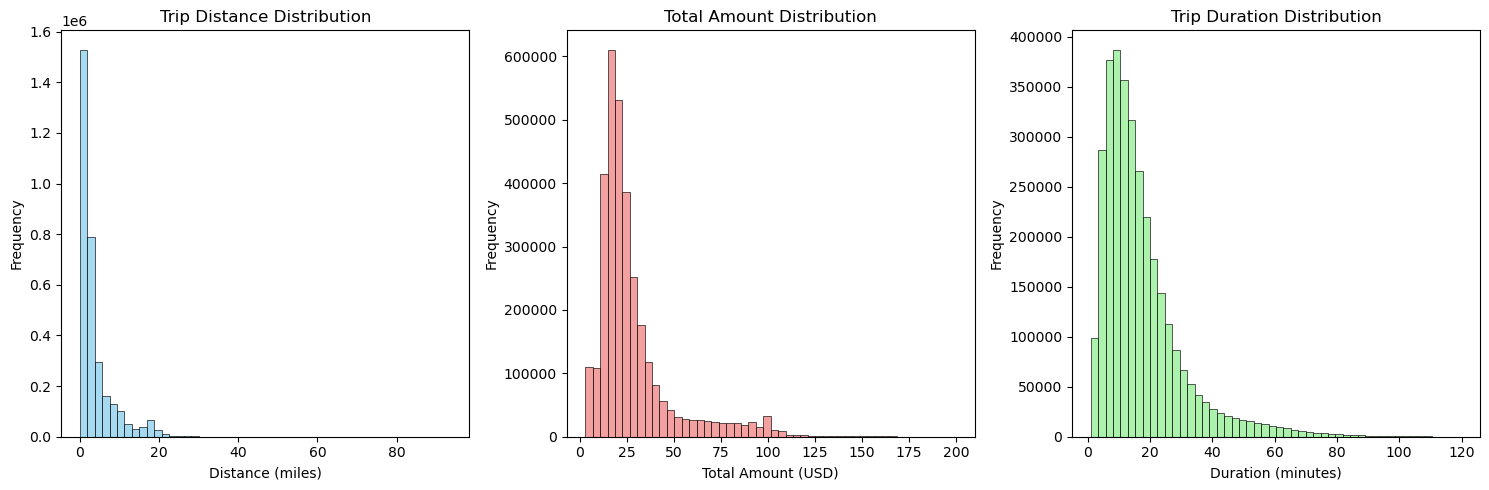

In [17]:
# Import visualization libraries
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For enhanced statistical visualizations

# Create a figure with 3 subplots arranged in 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # figsize=(width, height) in inches

# ============ Histogram 1: Trip Distance ============
sns.histplot(valid['trip_distance'], bins=50, ax=axes[0], color='skyblue', edgecolor='black')  # bins=50: divide data into 50 intervals
axes[0].set_title('Trip Distance Distribution')  # Set subplot title
axes[0].set_xlabel('Distance (miles)')  # Label for x-axis
axes[0].set_ylabel('Frequency')  # Label for y-axis (count of trips)

# ============ Histogram 2: Total Amount ============
sns.histplot(valid['total_amount'], bins=50, ax=axes[1], color='lightcoral', edgecolor='black')  # Red color for fare data
axes[1].set_title('Total Amount Distribution')  # Set subplot title
axes[1].set_xlabel('Total Amount (USD)')  # X-axis shows fare in US dollars
axes[1].set_ylabel('Frequency')  # Y-axis shows frequency count

# ============ Histogram 3: Trip Duration ============
sns.histplot(valid['duration_min'], bins=50, ax=axes[2], color='lightgreen', edgecolor='black')  # Green color for duration
axes[2].set_title('Trip Duration Distribution')  # Set subplot title
axes[2].set_xlabel('Duration (minutes)')  # X-axis shows time in minutes
axes[2].set_ylabel('Frequency')  # Y-axis shows frequency count

# Automatically adjust spacing between subplots to prevent overlap
plt.tight_layout()

## ⏰ Temporal Pattern Analysis

Analyze taxi usage patterns across different hours and days of the week to identify peak demand periods.


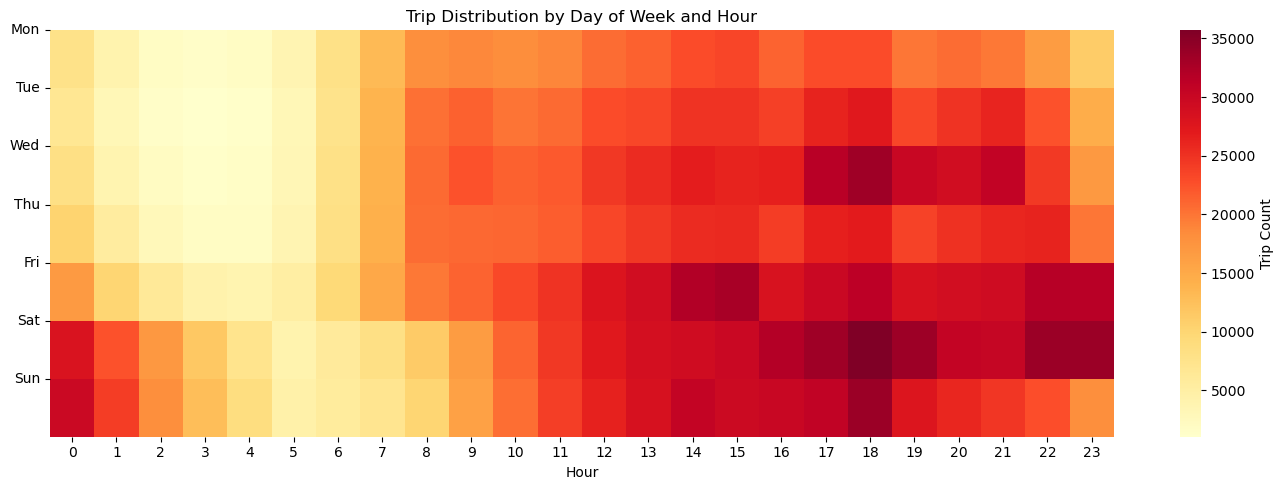

In [18]:
# ============ Extract time features from datetime ============
valid["hour"] = valid["tpep_pickup_datetime"].dt.hour  # Extract hour of day (0-23) from pickup time
valid["dow"] = valid["tpep_pickup_datetime"].dt.dayofweek  # Extract day of week (0=Mon, 1=Tue, ..., 6=Sun)

# ============ Aggregate trip counts by day and hour ============
hourly = valid.groupby(["dow", "hour"]).size().unstack(fill_value=0)  # Group by day+hour, count trips, pivot to matrix format
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]  # Day name labels for y-axis

# ============ Create figure canvas ============
plt.figure(figsize=(14, 5))  # Set figure size: 14 inches wide, 5 inches tall

# ============ Draw heatmap visualization ============
sns.heatmap(hourly, cmap="YlOrRd", cbar_kws={"label": "Trip Count"})

# ============ Customize axis labels and ticks ============
plt.xlabel("Hour")  # Label x-axis as Hour (0 to 23)
plt.ylabel("")  # Leave y-axis label empty (day names are self-explanatory)
plt.yticks(range(7), days, rotation=0)  # Replace numeric ticks (0-6) with day names, no rotation

# ============ Set title, adjust layout, and display ============
plt.title("Trip Distribution by Day of Week and Hour")  # Add descriptive title
plt.tight_layout()  # Optimize spacing to prevent label cutoff

## 🗺️ Geospatial Analysis

### Load NYC Taxi Zone Geographic Data

In [19]:
# Import geospatial data processing library
import geopandas as gpd  # GeoPandas extends pandas to work with geographic data

# Load NYC taxi zone boundaries from Shapefile
zones = gpd.read_file("taxi_zones/taxi_zones.shp")
# Shapefile (.shp) contains polygon geometries for each taxi zone in NYC

### Pickup Locations Heatmap

Visualize the spatial distribution of taxi pickups across NYC zones.


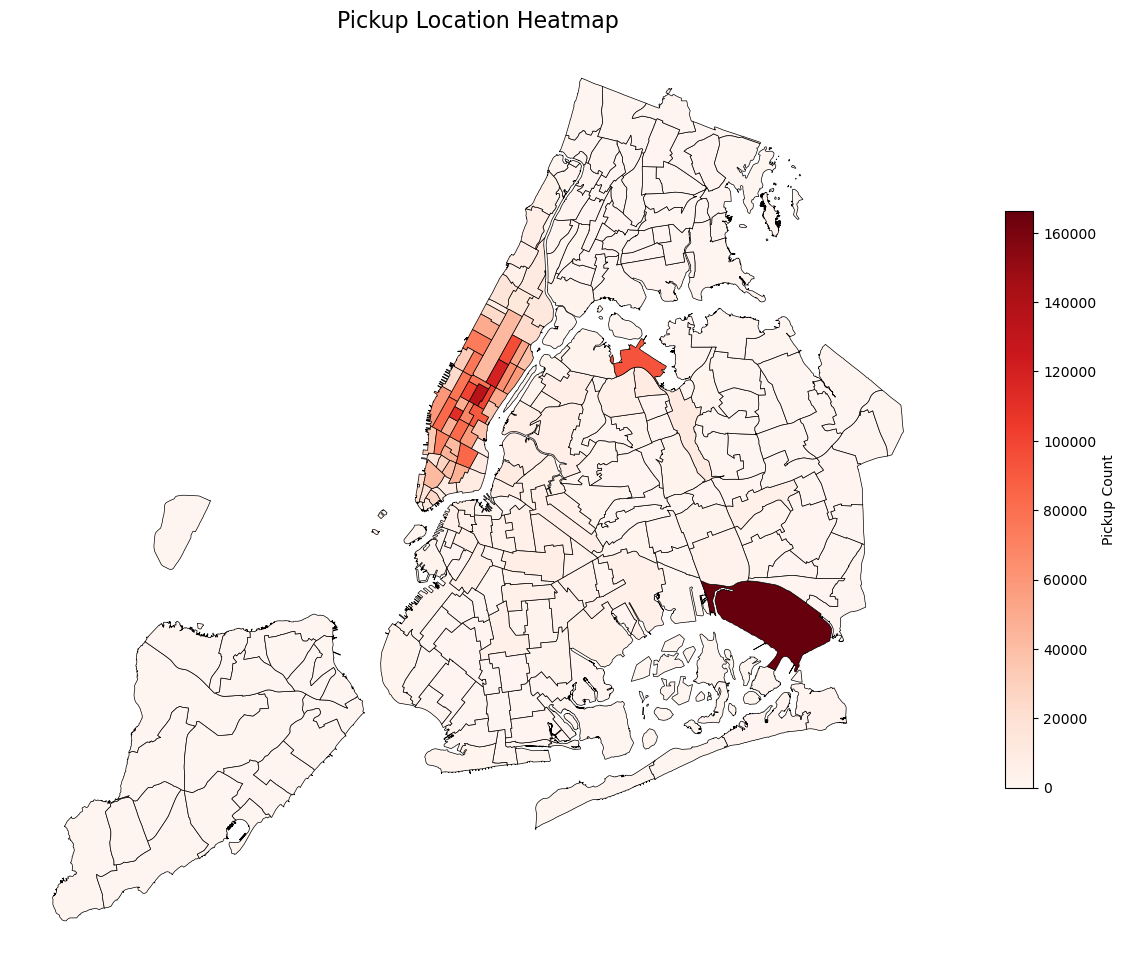


Top 10 Pickup Locations:
                        zone   borough    count
                 JFK Airport    Queens 166162.0
              Midtown Center Manhattan 135039.0
       Upper East Side South Manhattan 118885.0
Penn Station/Madison Sq West Manhattan 111945.0
                Midtown East Manhattan 101152.0
   Times Sq/Theatre District Manhattan 100161.0
       Upper East Side North Manhattan  96226.0
           LaGuardia Airport    Queens  93416.0
                 Murray Hill Manhattan  90769.0
                East Village Manhattan  83854.0


In [20]:
# ============ Count pickups by zone ============
pickup_counts = valid["PULocationID"].value_counts().reset_index()  # Count number of pickups for each zone ID
# value_counts(): aggregates by zone, reset_index(): converts series to dataframe
pickup_counts.columns = ["LocationID", "count"]  # Rename columns for clarity

# ============ Merge geographic and statistical data ============
zones_pickup = zones.merge(pickup_counts, on="LocationID", how="left").fillna(0)
# Merge zone geometries with pickup counts by matching LocationID
# how="left": keep all zones, even those with no pickups
# fillna(0): zones with no pickups get count=0

# ============ Create figure and axis ============
fig, ax = plt.subplots(figsize=(12, 10))  # Create 12x10 inch figure

# ============ Draw choropleth map (geographic heatmap) ============
zones_pickup.plot(
    column="count",  # Color each zone based on pickup count
    cmap="Reds",  # Color scheme: white (low) to dark red (high)
    legend=True,  # Display color scale legend
    ax=ax,  # Plot on the specified axis
    edgecolor="black",  # Draw zone boundaries in black
    linewidth=0.5,  # Boundary line thickness
    legend_kwds={"label": "Pickup Count", "shrink": 0.6}  # Customize legend: add label, reduce size to 60%
)

# ============ Customize plot appearance ============
ax.set_title("Pickup Location Heatmap", fontsize=16)  # Set title with font size
ax.axis("off")  # Hide coordinate axes for cleaner map
plt.tight_layout()  # Optimize spacing
plt.show()  # Display the map

# ============ Print top 10 pickup locations ============
print("\nTop 10 Pickup Locations:")  # Print section header
top_pu = zones_pickup.nlargest(10, "count")[["zone", "borough", "count"]]  # Select top 10 zones, keep 3 columns
print(top_pu.to_string(index=False))  # Print table without row numbers

Using logarithmic scale to better visualize the wide range of pickup volumes.

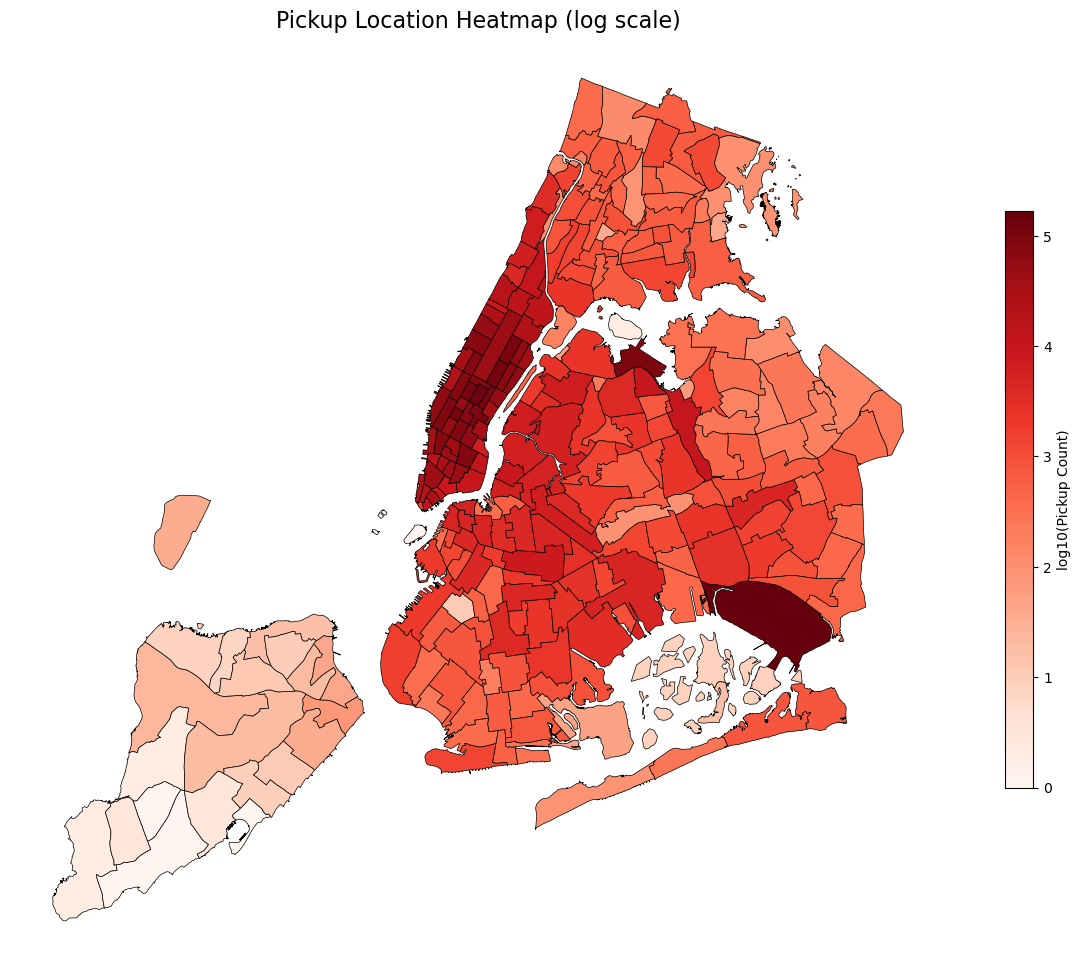


Top 10 Pickup Locations:
                        zone   borough    count
                 JFK Airport    Queens 166162.0
              Midtown Center Manhattan 135039.0
       Upper East Side South Manhattan 118885.0
Penn Station/Madison Sq West Manhattan 111945.0
                Midtown East Manhattan 101152.0
   Times Sq/Theatre District Manhattan 100161.0
       Upper East Side North Manhattan  96226.0
           LaGuardia Airport    Queens  93416.0
                 Murray Hill Manhattan  90769.0
                East Village Manhattan  83854.0


In [13]:
# ============ Apply logarithmic transformation ============
# Why log scale? Pickup counts have huge range (e.g., 10 to 100,000)
# Log scale compresses the range and makes patterns more visible
zones_pickup["log_count"] = np.log10(zones_pickup["count"] + 1)
# np.log10(): base-10 logarithm
# +1: prevents log(0) error for zones with zero pickups

# ============ Create figure and axis ============
fig, ax = plt.subplots(figsize=(12, 10))  # Create 12x10 inch figure

# ============ Draw choropleth map with log scale ============
zones_pickup.plot(
    column="log_count",  # Color zones by log10-transformed pickup count
    cmap="Reds",  # Red color gradient
    legend=True,  # Display color scale legend
    ax=ax,  # Plot on the axis
    edgecolor="black",  # Black zone boundaries
    linewidth=0.5,  # Boundary thickness
    legend_kwds={"label": "log10(Pickup Count)", "shrink": 0.6}  # Legend shows it's log scale
)

# ============ Customize and display ============
ax.set_title("Pickup Location Heatmap (log scale)", fontsize=16)  # Title indicates log scale
ax.axis("off")  # Hide axes for cleaner map
plt.tight_layout()  # Optimize spacing
plt.show()  # Display the map

# ============ Print top 10 pickup locations ============
print("\nTop 10 Pickup Locations:")  # Print section header
top_pu = zones_pickup.nlargest(10, "count")[["zone", "borough", "count"]]  # Get top 10 by original count (not log)
print(top_pu.to_string(index=False))  # Display as table without row indices

### Dropoff Locations Heatmap

Visualize the spatial distribution of taxi dropoffs across NYC zones.


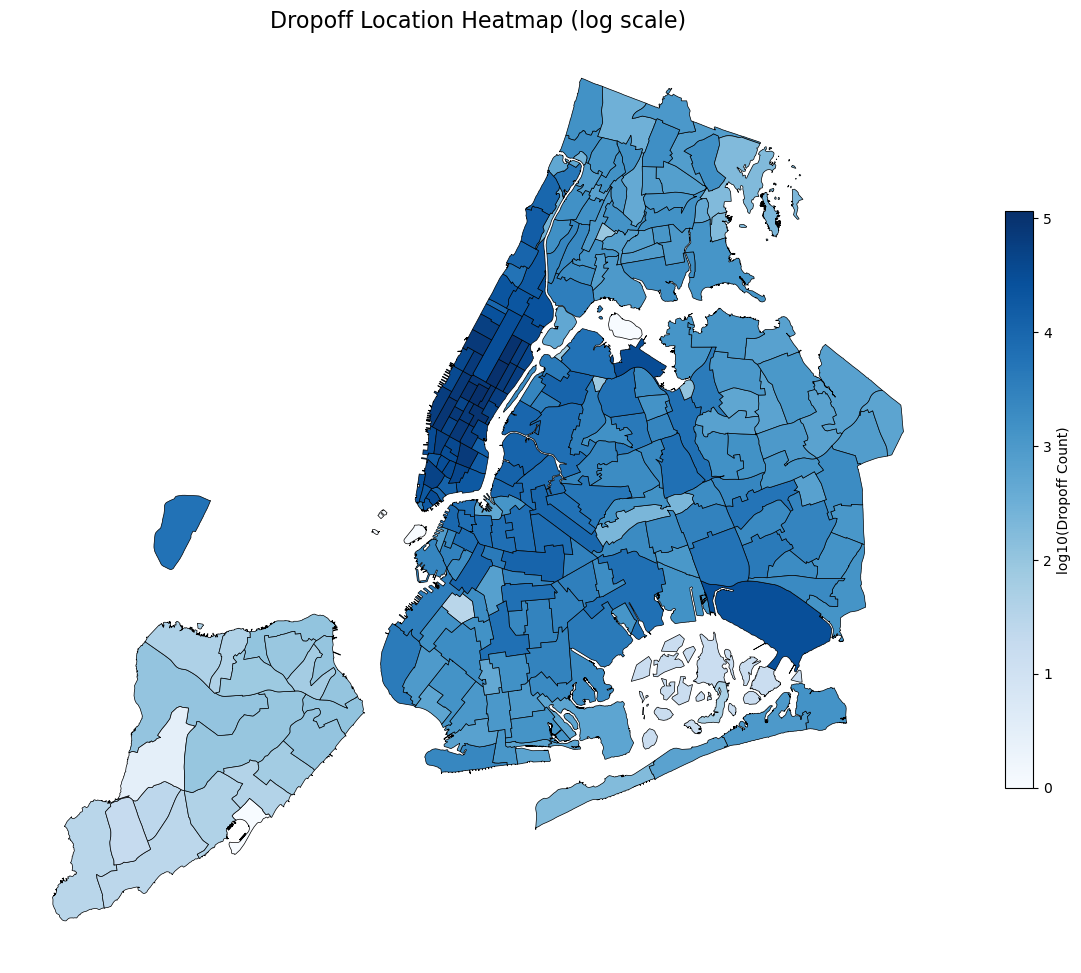

In [14]:
# ============ Count dropoffs by zone ============
dropoff_counts = valid["DOLocationID"].value_counts().reset_index()  # Count dropoffs per zone ID
# DOLocationID: Dropoff Location ID column
dropoff_counts.columns = ["LocationID", "count"]  # Rename for consistency

# ============ Merge geographic and count data ============
zones_dropoff = zones.merge(dropoff_counts, on="LocationID", how="left").fillna(0)
# Join dropoff counts to zone geometries by LocationID
# fillna(0): zones with no dropoffs get 0

# ============ Apply logarithmic transformation ============
zones_dropoff["log_count"] = np.log10(zones_dropoff["count"] + 1)
# Log scale compresses wide range of values for better visualization
# +1 prevents undefined log(0)

# ============ Create figure and axis ============
fig, ax = plt.subplots(figsize=(12, 10))  # 12x10 inch figure

# ============ Draw choropleth map ============
zones_dropoff.plot(
    column="log_count",  # Color by log-transformed dropoff count
    cmap="Blues",  # Blue color gradient (different from pickup's red)
    legend=True,  # Show color scale
    ax=ax,  # Specify axis
    edgecolor="black",  # Black boundaries
    linewidth=0.5,  # Boundary width
    legend_kwds={"label": "log10(Dropoff Count)", "shrink": 0.6}  # Legend configuration
)

# ============ Customize and display ============
ax.set_title("Dropoff Location Heatmap (log scale)", fontsize=16)  # Descriptive title
ax.axis("off")  # Hide coordinate axes
plt.tight_layout()  # Adjust spacing
plt.show()  # Display map

In [15]:
# ============ Print top 10 dropoff locations ============
print("\nTop 10 Dropoff Locations:")  # Print section header
top_do = zones_dropoff.nlargest(10, "count")[["zone", "borough", "count"]]
# nlargest(10, "count"): get 10 zones with highest dropoff counts
# [["zone", "borough", "count"]]: select only these 3 columns
print(top_do.to_string(index=False))  # Display table without row numbers


Top 10 Dropoff Locations:
                        zone   borough    count
              Midtown Center Manhattan 113890.0
       Upper East Side South Manhattan 107758.0
       Upper East Side North Manhattan 102488.0
   Times Sq/Theatre District Manhattan 100158.0
                 Murray Hill Manhattan  93572.0
                Midtown East Manhattan  88122.0
                East Chelsea Manhattan  83573.0
                Clinton East Manhattan  77516.0
                    Union Sq Manhattan  75817.0
Penn Station/Madison Sq West Manhattan  75631.0


### Origin-Destination (OD) Flow Analysis

Analyze and visualize the most popular taxi routes connecting different zones in NYC.


In [21]:
# ============ Aggregate trips by Origin-Destination (OD) pairs ============
od_flow = valid.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="count")
# groupby(): group trips by pickup zone AND dropoff zone
# size(): count trips for each unique OD pair
# reset_index(): convert to dataframe with columns: PULocationID, DOLocationID, count

od_flow = od_flow.sort_values("count", ascending=False)  # Sort OD pairs by trip count (highest first)

print(f"Total OD pairs: {len(od_flow):,}")  # Display total number of unique OD pairs

# ============ Calculate zone centroids (center points) ============
zones_center = zones.copy()  # Make a copy to avoid modifying original zones data
zones_center["centroid"] = zones_center.geometry.centroid
# .centroid: calculate geometric center of each zone polygon
# We'll draw lines from pickup centroid to dropoff centroid

# ============ Import geometry library for creating lines ============
from shapely.geometry import LineString  # LineString creates a line between two points

# ============ Initialize lists to store OD flow line data ============
lines = []  # Will store LineString geometries (the lines on map)
counts = []  # Will store trip counts for each line
pu_coords = []  # Pickup (x, y) coordinates
do_coords = []  # Dropoff (x, y) coordinates
pu_zones = []  # Pickup zone names
do_zones = []  # Dropoff zone names

print("Creating OD flow lines...")
# Loop through each OD pair to create corresponding line geometry
for _, row in od_flow.iterrows():  # Iterate through each row in od_flow
    # Find the zone geometry for pickup location
    pu = zones_center[zones_center["LocationID"] == row["PULocationID"]]
    # Find the zone geometry for dropoff location
    do = zones_center[zones_center["LocationID"] == row["DOLocationID"]]

    # Only create line if both pickup and dropoff zones exist in our shapefile
    if len(pu) > 0 and len(do) > 0:
        pu_centroid = pu.iloc[0]["centroid"]  # Get pickup zone's centroid
        do_centroid = do.iloc[0]["centroid"]  # Get dropoff zone's centroid

        # Create a straight line from pickup centroid to dropoff centroid
        line = LineString([pu_centroid, do_centroid])

        # Append all data to respective lists
        lines.append(line)  # Add line geometry
        counts.append(row["count"])  # Add trip count
        pu_coords.append((pu_centroid.x, pu_centroid.y))  # Add pickup coordinates
        do_coords.append((do_centroid.x, do_centroid.y))  # Add dropoff coordinates
        pu_zones.append(pu.iloc[0]["zone"])  # Add pickup zone name
        do_zones.append(do.iloc[0]["zone"])  # Add dropoff zone name

# ============ Create GeoDataFrame for OD flows ============
od_gdf = gpd.GeoDataFrame({
    "count": counts,  # Trip counts
    "geometry": lines,  # Line geometries
    "pu_zone": pu_zones,  # Pickup zone names
    "do_zone": do_zones  # Dropoff zone names
}, crs=zones.crs)  # crs: Coordinate Reference System (must match zone data)

print(f"Created {len(od_gdf):,} OD flow lines")  # Confirm number of lines created

Total OD pairs: 39,759
Creating OD flow lines...
Created 39,051 OD flow lines


Selected top 1000 routes out of 39,051 total OD pairs
Top 1000 trip count range: 871 to 14,087
Drawing top 1,000 OD flow lines...


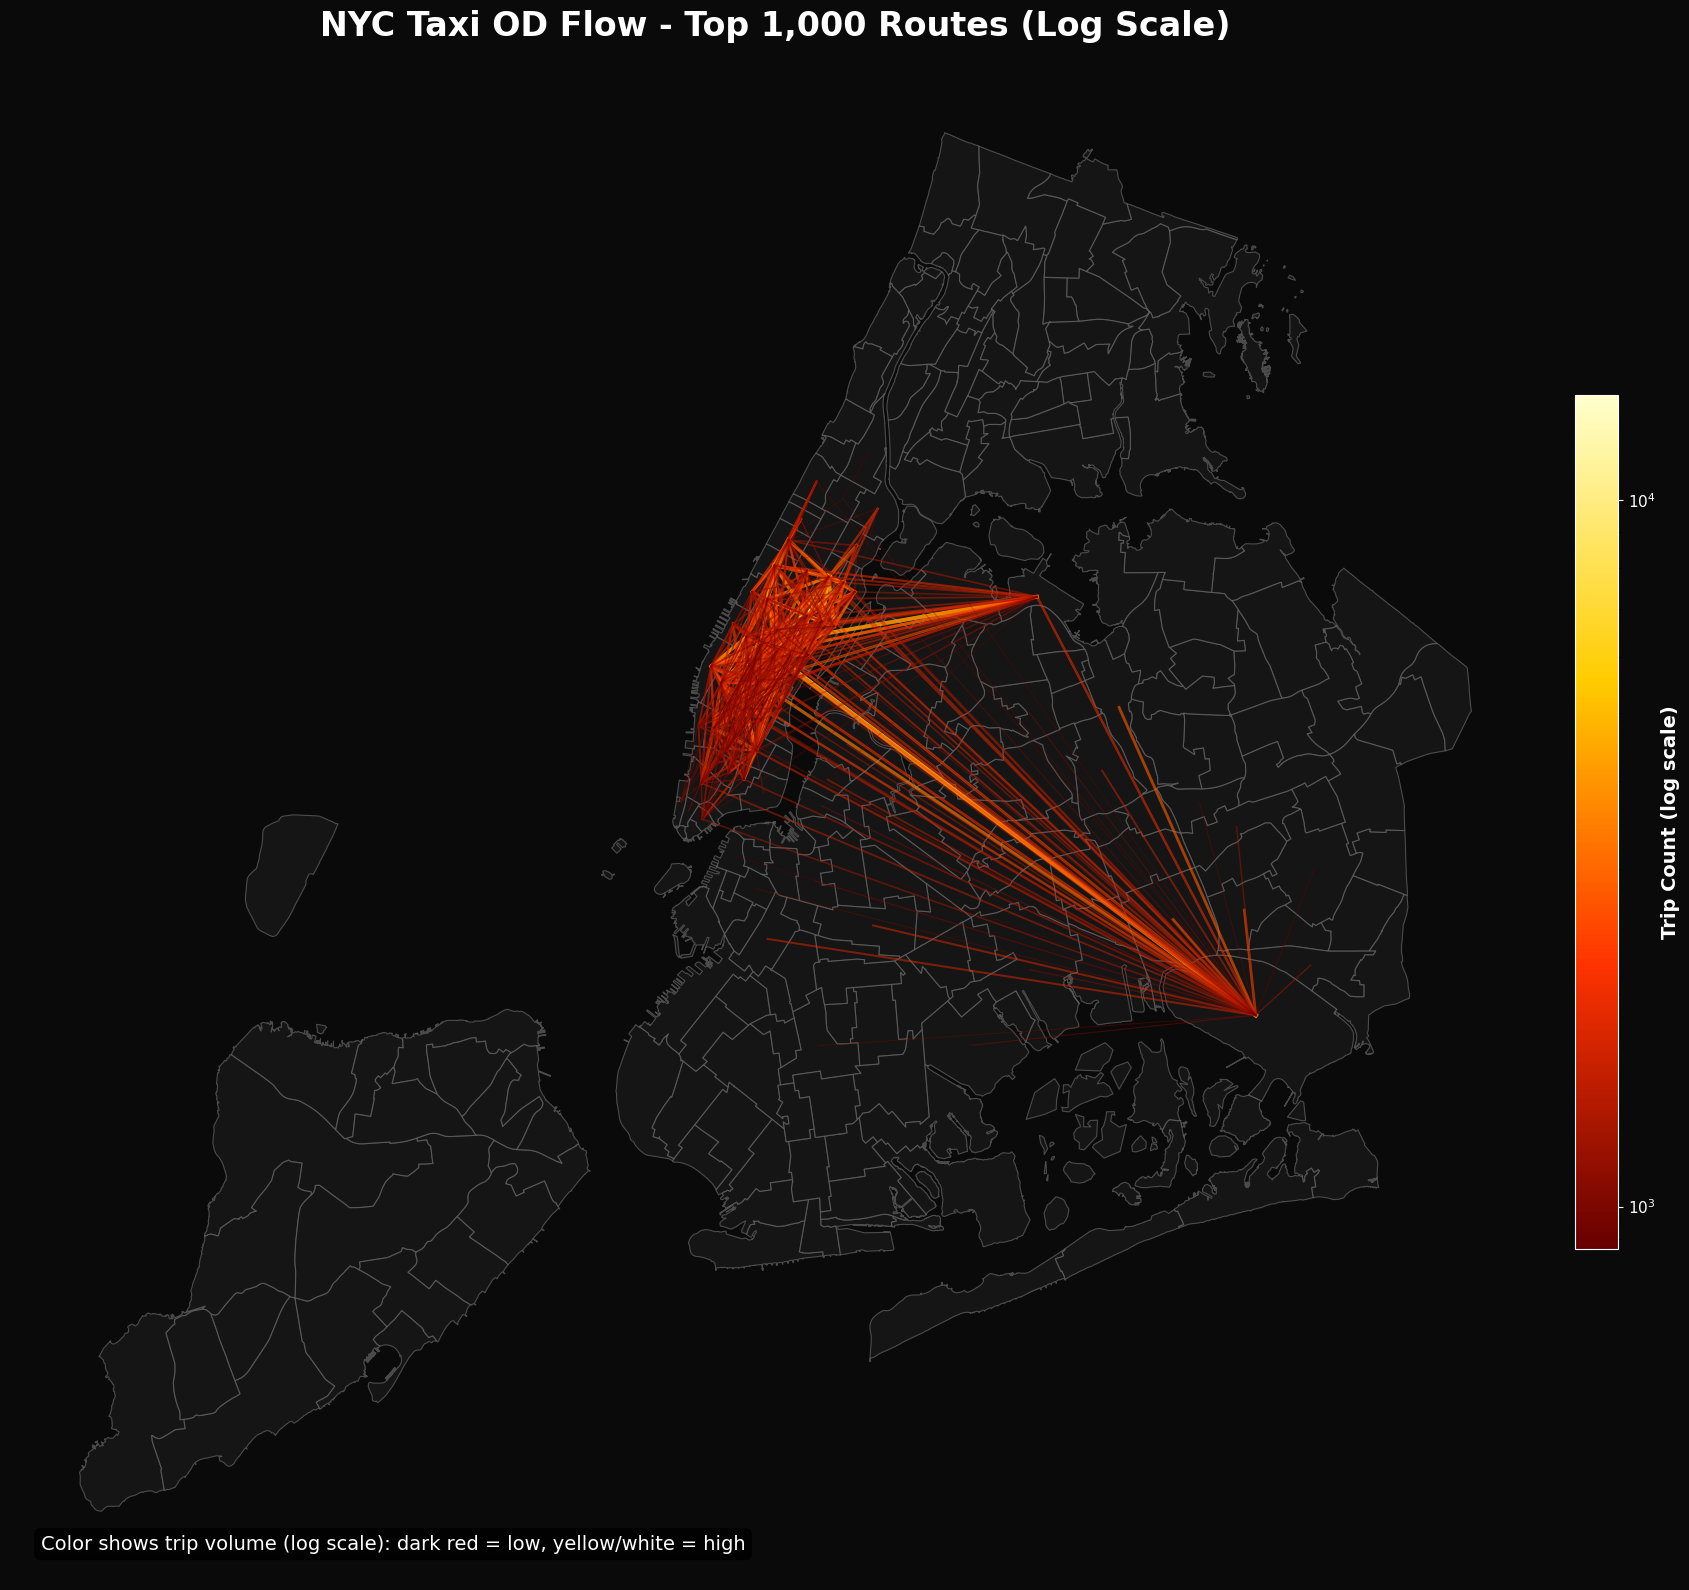

✅ Finished drawing top 1,000 routes!
   These routes account for the highest trip volumes in NYC


In [22]:
# ============ Import color mapping utilities ============
from matplotlib.colors import LogNorm, LinearSegmentedColormap  # For log-scale color normalization
from matplotlib import cm  # ColorMap utilities

# ============ Select top 1000 routes for visualization ============
# Why only 1000? Drawing all OD pairs (~60,000) would make the map too cluttered
od_gdf_top = od_gdf.sort_values("count", ascending=False).head(1000).copy()
# sort_values(): sort by trip count, descending
# head(1000): keep only top 1000 routes

print(f"Selected top 1000 routes out of {len(od_gdf):,} total OD pairs")
print(f"Top 1000 trip count range: {od_gdf_top['count'].min():.0f} to {od_gdf_top['count'].max():,.0f}")

# ============ Create figure with dark background ============
fig, ax = plt.subplots(figsize=(18, 16), facecolor='#0a0a0a')  # 18x16 inch, very dark background
ax.set_facecolor('#0a0a0a')  # Set plot area background to same dark color

# ============ Draw base map (zone boundaries) ============
zones.plot(ax=ax, color='#1a1a1a', edgecolor='#666666', linewidth=0.8, alpha=0.7)
# color='#1a1a1a': very dark gray fill for zones
# edgecolor='#666666': medium gray for boundaries
# alpha=0.7: slight transparency

# ============ Create custom color gradient ============
colors = ['#660000', '#ff3300', '#ffcc00', '#ffffcc']
# Dark red → bright red → orange → pale yellow/white
# This creates a "heat" effect: cool (low volume) to hot (high volume)
cmap = LinearSegmentedColormap.from_list("bright_warm", colors, N=256)
# N=256: create 256 color steps for smooth gradient

# ============ Set up logarithmic color normalization ============
counts = od_gdf_top["count"].fillna(1).to_numpy()  # Convert counts to numpy array, fill missing with 1
norm = LogNorm(vmin=max(counts.min(), 1), vmax=counts.max())
# LogNorm: map values to colors using logarithmic scale
# vmin/vmax: minimum and maximum values for color mapping

print(f"Drawing top {len(od_gdf_top):,} OD flow lines...")

# ============ Define line width range ============
max_w = 4.2  # Maximum line width (for highest volume routes)
min_w = 0.5  # Minimum line width (for lowest volume routes)

# ============ Draw each OD flow line ============
for _, row in od_gdf_top.iterrows():  # Loop through each of the top 1000 routes
    # Get trip count, ensure it's at least 1 (avoid log(0))
    cnt = max(1, float(row["count"]) if not pd.isna(row["count"]) else 1)

    # ---- Map count to color using log scale ----
    color = cmap(norm(cnt))  # norm(cnt): normalize count to 0-1 range, cmap(): map to color

    # ---- Calculate line width and transparency based on volume ----
    # Normalize count to 0-1 range using log scale
    log_t = (np.log10(cnt) - np.log10(counts.min())) / (np.log10(counts.max()) - np.log10(counts.min()))
    # Map normalized value to line width range
    linewidth = min_w + log_t * (max_w - min_w)
    # Map to alpha (transparency): 0.35 (low volume) to 1.0 (high volume)
    alpha = np.clip(0.35 + log_t * 0.65, 0.0, 1.0)  # clip: ensure value stays in 0-1 range

    # ---- Extract line coordinates ----
    try:
        coords = list(row.geometry.coords)  # Get (x,y) coordinates of line endpoints
        if len(coords) < 2:  # Skip if line doesn't have 2 endpoints
            continue
        (x0, y0), (x1, y1) = coords[0], coords[1]  # Extract start and end points
    except Exception:  # Skip if any error occurs
        continue

    # ---- Draw the line ----
    ax.plot([x0, x1], [y0, y1],  # Draw from (x0,y0) to (x1,y1)
            color=color,  # Use calculated color
            linewidth=linewidth,  # Use calculated width
            alpha=alpha,  # Use calculated transparency
            zorder=2)  # zorder=2: draw lines above base map (which has default zorder=1)

# ============ Add title and description ============
ax.set_title(f"NYC Taxi OD Flow - Top {len(od_gdf_top):,} Routes (Log Scale)",
             fontsize=24, color='white', fontweight='bold', pad=20)
# Add explanatory text in bottom-left corner
ax.text(0.02, 0.02,  # Position at 2% from left, 2% from bottom
        'Color shows trip volume (log scale): dark red = low, yellow/white = high',
        transform=ax.transAxes,  # Use axes coordinates (0-1) instead of data coordinates
        fontsize=14, color='white',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))  # Black rounded box background

ax.axis("off")  # Hide coordinate axes

# ============ Add colorbar (legend) ============
sm = cm.ScalarMappable(cmap=cmap, norm=norm)  # Create mappable object for colorbar
sm.set_array([])  # Required by matplotlib (empty array is fine)
cbar = plt.colorbar(sm, ax=ax, fraction=0.025, pad=0.02)  # Create colorbar: 2.5% of plot width
cbar.set_label('Trip Count (log scale)', color='white', fontsize=14, fontweight='bold')
cbar.ax.yaxis.set_tick_params(color='white', labelsize=11)  # White tick marks
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')  # White tick labels
cbar.outline.set_edgecolor('white')  # White colorbar border

# ============ Display the visualization ============
plt.tight_layout()  # Adjust spacing
plt.show()  # Render and display

print(f"✅ Finished drawing top {len(od_gdf_top):,} routes!")
print(f"   These routes account for the highest trip volumes in NYC")
